In [1]:
import numpy as np
import multiprocessing #多线程处理
import cv2
import matplotlib.pyplot as plt #绘图


import rosbag #处理rosbag
from cv_bridge import CvBridge

import sys
sys.path.append('/home/gwp/rpg_vid2e/rosbag_reading')  # 替换为实际的路径(注意如果修改了py文件的代码需要重新restart kernel)
from utils.bag_utils import read_H_W_from_bag, read_tss_us_from_rosbag, read_images_from_rosbag, read_evs_from_rosbag, read_calib_from_bag, read_t0us_evs_from_rosbag, read_poses_from_rosbag
print("import ultils to process the rosbag")

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


import ultils to process the rosbag


In [2]:
rosbag_file="../example/HKU-dataset/HKU_aggressive_small_flip.bag"
# 从rosbag文件中读取数据
bag_data = rosbag.Bag(rosbag_file, "r")

topics = list(bag_data.get_type_and_topic_info()[1].keys())
print("all the topic name in this rosbag",topics)

all the topic name in this rosbag ['/cpy_uav/viconros/odometry', '/davis_left/events', '/davis_left/image_raw', '/davis_left/imu', '/davis_right/events', '/davis_right/image_raw', '/davis_right/imu']


In [3]:
event_topic_name='/davis_left/events';
image_topic_name='/davis_left/image_raw';
# 下面的写法太耗费时间了~
# event_iterator = bag_data.read_messages(topics=[event_topic_name])
# event_msg_list = list(event_iterator)
# print("the number of event messages is ",len(event_msg_list))
# image_iterator = bag_data.read_messages(topics=[image_topic_name])
# image_msg_list = list(image_iterator)
# print("the number of image messages is ",len(image_msg_list))

# 读取图像的长与宽
H, W = read_H_W_from_bag(bag_data, image_topic_name)
# 读取图像数据
imgs = read_images_from_rosbag(bag_data, image_topic_name, H=H, W=W)


Read H, W from bag: 260, 346


  0%|          | 0/1726 [00:00<?, ?it/s]

 27%|██▋       | 461/1726 [00:10<00:24, 52.37it/s]

 62%|██████▏   | 1070/1726 [00:25<00:15, 43.43it/s]

100%|██████████| 1726/1726 [00:41<00:00, 41.71it/s]


In [7]:
# 读取最开始的事件的时间
# t0_events = read_t0us_evs_from_rosbag(bag_data, event_topic_name)

# 读取事件数据
all_events = read_evs_from_rosbag(bag_data, event_topic_name, H=H, W=W)


Start reading evs from /davis_left/events,事件的极性为1和-1


100%|██████████| 4466/4466 [26:16<00:00,  2.83it/s] 


In [35]:
print("the number of all event",len(all_events))

# 转换一下存储格式
transformed_events = {
    'x': np.array([event['x'] for event in all_events]),
    'y': np.array([event['y'] for event in all_events]),
    't': np.array([event['t'] for event in all_events]),
    'p': np.array([event['p'] for event in all_events])
}

print("the number of all event",len(transformed_events['x']))

the number of all event 103119634
the number of all event 103119634


In [46]:
event_index=1000;
print("the event:",all_events[event_index])
print("the event x:",all_events[event_index]['x'])
print("the event y:",all_events[event_index]['y'])
print("the event t:",all_events[event_index]['t'])
print("the event p:",all_events[event_index]['p'])

print("the event x:",transformed_events['x'][event_index])
print("the event y:",transformed_events['y'][event_index])
print("the event t:",transformed_events['t'][event_index])
print("the event p:",transformed_events['p'][event_index])  

the event: {'x': 50, 'y': 210, 't': 1666333971342438.8, 'p': 1}
the event x: 50
the event y: 210
the event t: 1666333971342438.8
the event p: 1
the event x: 50
the event y: 210
the event t: 1666333971342438.8
the event p: 1


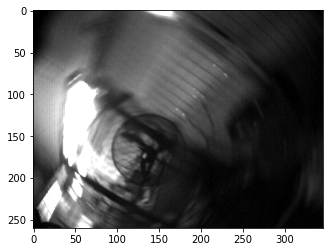

the timestamp of the image is  1666334010130768.8
can select the events timestamp (us) is form  1666334010086217.8  to  1666334010130768.8
 number of True values in the mask: 80480
Number of events: 80480


In [47]:
# 看看一张图片
image_index=900;
image=imgs[image_index]
image_color = np.stack([image,image,image],-1)#将三个图像叠加，并沿着最后一个维度堆叠，形成一个彩色图像（RGB）。
plt.imshow(image_color)
plt.show()

#获取这种图片对于的相邻的时间戳
# 读取图像的时间戳
timestamp_imgs_us = read_tss_us_from_rosbag(bag_data, image_topic_name)
assert len(timestamp_imgs_us) == len(imgs)

timestamp_us_0=timestamp_imgs_us[image_index-1];#上一张图片的时间戳
timestamp_us_1=timestamp_imgs_us[image_index];#当前图片的时间戳
print("the timestamp of the image is ",timestamp_us_1)
print("can select the events timestamp (us) is form ",timestamp_us_0," to ",timestamp_us_1)
 

 # # 提取在某个时间段内的事件
mask = (transformed_events['t'] >= timestamp_us_0) & (transformed_events['t'] < timestamp_us_1)
# Count the number of True values in the mask
print(" number of True values in the mask:",np.count_nonzero(mask))
event_stream = {k: v[mask] for k, v in transformed_events.items()}
num_event=len(event_stream['t'])
print("Number of events:", num_event)

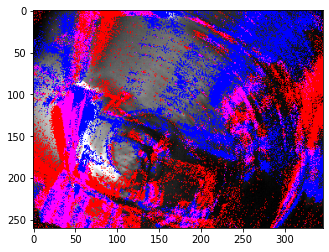

In [48]:
# 将事件数据与图像一起可视化出来
image_color[event_stream['y'], event_stream['x'], :] = 0 #将事件的位置设置为黑色
# 由于是BGR，所以-1的时候，对应1-1是蓝色，1的时候，1+1是红色
image_color[event_stream['y'], event_stream['x'], 1+event_stream['p']] = 255

plt.imshow(image_color)
plt.show()